# Data Configuration

## Import packages & Basic settings

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
!pip install -q tf-nightly

In [3]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.enable_eager_execution()
import os

import numpy as np

import matplotlib.pyplot as plt

keras = tf.keras
tf.VERSION

'1.14.1-dev20190605'

## Data load

In [4]:
import pathlib
import os
pth = '/gdrive/My Drive/img_dataset/beer_dataset/traint/'
data_root=pathlib.Path(pth)
print(data_root)

/gdrive/My Drive/img_dataset/beer_dataset/traint


In [5]:
for item in data_root.iterdir():
  print(item)

/gdrive/My Drive/img_dataset/beer_dataset/traint/guinness
/gdrive/My Drive/img_dataset/beer_dataset/traint/tsingtao
/gdrive/My Drive/img_dataset/beer_dataset/traint/cass
/gdrive/My Drive/img_dataset/beer_dataset/traint/cp-0006.ckpt.data-00000-of-00001
/gdrive/My Drive/img_dataset/beer_dataset/traint/cp-0006.ckpt.index
/gdrive/My Drive/img_dataset/beer_dataset/traint/cp-0001.ckpt.index
/gdrive/My Drive/img_dataset/beer_dataset/traint/cp-0001.ckpt.data-00000-of-00001
/gdrive/My Drive/img_dataset/beer_dataset/traint/cp-0002.ckpt.index
/gdrive/My Drive/img_dataset/beer_dataset/traint/cp-0002.ckpt.data-00000-of-00001
/gdrive/My Drive/img_dataset/beer_dataset/traint/cp-0003.ckpt.index
/gdrive/My Drive/img_dataset/beer_dataset/traint/cp-0003.ckpt.data-00000-of-00001
/gdrive/My Drive/img_dataset/beer_dataset/traint/cp-0004.ckpt.index
/gdrive/My Drive/img_dataset/beer_dataset/traint/cp-0004.ckpt.data-00000-of-00001
/gdrive/My Drive/img_dataset/beer_dataset/traint/cp-0005.ckpt.index
/gdrive/My D

In [6]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

img_count = len(all_image_paths)
img_count

1230

## Check the loaded  images

In [7]:
all_image_paths[:10]

['/gdrive/My Drive/img_dataset/beer_dataset/traint/guinness/gui (54).png',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/cass (668).png',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/cass (74).png',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/cass (526).png',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/cass (435).png',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/cass (305).png',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/guinness/gui (287).png',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/cass (205).png',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/scene00691 (3).jpg',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/guinness/gui (71).png']

In [0]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image : " + ' - '.join(str(image_rel).split('-'))
    

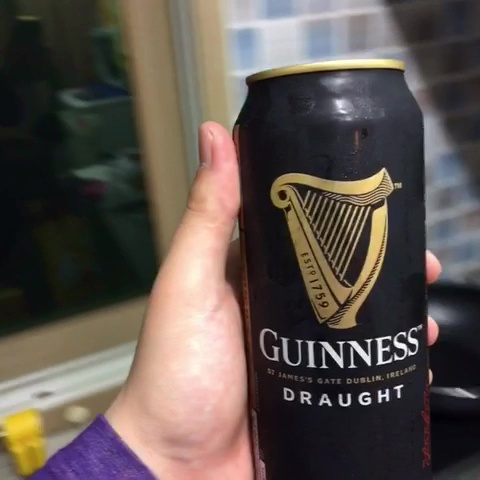

Image : guinness/scene00646.jpg



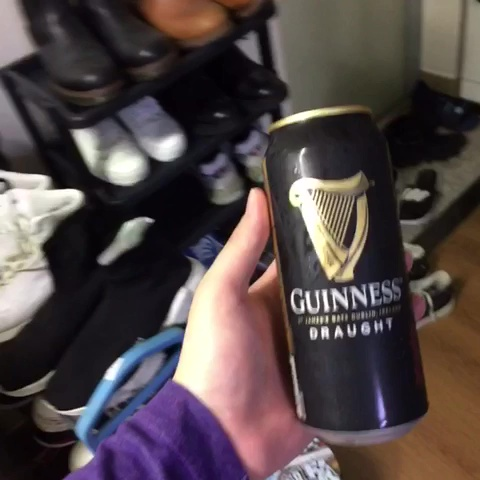

Image : guinness/scene00451.jpg



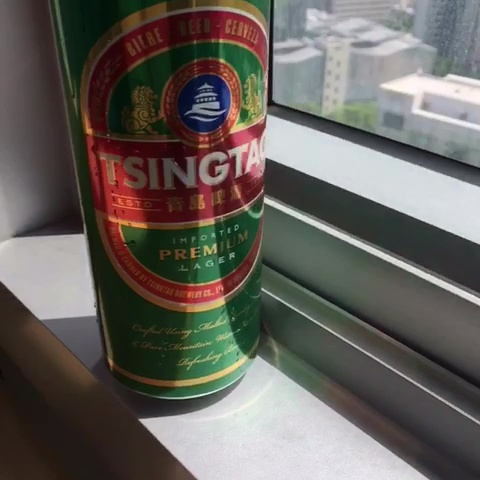

Image : tsingtao/scene00751 (3).jpg



In [9]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

## Embedding label

In [10]:
label_names= sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['cass', 'guinness', 'tsingtao']

In [11]:
label_to_index = dict((name,index)for index,name in enumerate(label_names))
label_to_index

{'cass': 0, 'guinness': 1, 'tsingtao': 2}

In [12]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                   for path in all_image_paths]

print("First 10 labels indices : ", all_image_labels[:10])


First 10 labels indices :  [1, 0, 0, 0, 0, 0, 1, 0, 0, 1]


## Split data ( train & validation set )

Each datasets are encapsulated as a Dataset objects

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize_images(image, [224, 224])
  image /= 255.0  # normalize to [0,1] range

  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

In [0]:
train_path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths[:int(img_count*0.9)])
val_path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths[int(img_count*0.9):img_count])

In [16]:
print(train_path_ds)

<DatasetV1Adapter shapes: (), types: tf.string>


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_image_ds = train_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_image_ds = val_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [0]:
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels[:int(img_count*0.9)], tf.int64))
val_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels[int(img_count*0.9):img_count], tf.int64))

In [19]:
print(train_image_ds)
print(train_label_ds)

<DatasetV1Adapter shapes: (224, 224, 3), types: tf.float32>
<DatasetV1Adapter shapes: (), types: tf.int64>


In [0]:
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
val_image_label_ds = tf.data.Dataset.zip((val_image_ds, val_label_ds))

In [21]:
print('image shape: ', train_image_label_ds.output_shapes[0])
print('label shape: ', train_image_label_ds.output_shapes[1])
print('types: ', train_image_label_ds.output_types)
print()
print(train_image_label_ds)

W0606 05:56:27.038401 139934958139264 deprecation.py:323] From <ipython-input-21-fd3f6d97daff>:1: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W0606 05:56:27.042526 139934958139264 deprecation.py:323] From <ipython-input-21-fd3f6d97daff>:3: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


image shape:  (224, 224, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


# Train phase

## Model setting

In [0]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable=False

In [23]:
BATCH_SIZE = 64
train_ds = train_image_label_ds.shuffle(buffer_size=int(img_count*0.9))
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
print(train_ds)

val_ds = val_image_label_ds.shuffle(buffer_size=int(img_count*0.1))
val_ds = val_ds.repeat()
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
print(val_ds)

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int64)>


In [0]:
def chage_range(image,label):
    return 2*image-1, label

keras_train_ds =train_ds.map(chage_range)
keras_val_ds =val_ds.map(chage_range)

In [0]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
train_image_batch, train_label_batch = next(iter(keras_train_ds))
val_image_batch, val_label_batch = next(iter(keras_val_ds))


In [26]:
train_feature_map_batch = base_model(train_image_batch)
print(train_feature_map_batch.shape)

(64, 5, 5, 2048)


In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names),activation='softmax')])

In [28]:
logit_batch = model(train_image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -1.991851
max logit: 2.5412178

Shape: (64, 3)


## Optimizer setting

In [29]:
model.summary()
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [30]:
len(model.trainable_variables) 

2

In [31]:
steps_per_epoch=tf.ceil(int(img_count*0.9)/BATCH_SIZE).numpy()
val_step=tf.ceil(int((img_count)*0.1)/BATCH_SIZE).numpy()

print(steps_per_epoch)
initial_epochs=3

18.0


In [32]:
checkpoint_path= pth + 'cp-FineTunend-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    period=1)

W0606 05:57:03.161954 139934958139264 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [33]:
checkpoint_path = '/gdrive/My Drive/checkpoints/cp-0010.ckpt'
model.load_weights(checkpoint_path)
loss,acc = model.evaluate(val_ds, steps=val_step)
print("복원된 모델의 validation 정확도: {:5.2f}%".format(100*acc))

2/2 [==============================] - 16s 8s/step - loss: 1.1609 - acc: 0.5859
복원된 모델의 validation 정확도: 58.59%


In [34]:
model.summary()
model.compile(optimizer=tf.train.AdamOptimizer (learning_rate=0.0001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [35]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [cp_callback],
                    validation_data=val_ds,
                    validation_steps=val_step,
                    )

Epoch 1/3


W0606 05:57:27.008059 139934958139264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


17/18 [===========================>..] - ETA: 8s - loss: 0.9790 - acc: 0.7574 
Epoch 00001: saving model to /gdrive/My Drive/img_dataset/beer_dataset/traint/cp-FineTunend-0001.ckpt
18/18 [==============================] - 178s 10s/step - loss: 0.9761 - acc: 0.7578 - val_loss: 1.1489 - val_acc: 0.5938
Epoch 2/3
17/18 [===========================>..] - ETA: 8s - loss: 0.9310 - acc: 0.7546 
Epoch 00002: saving model to /gdrive/My Drive/img_dataset/beer_dataset/traint/cp-FineTunend-0002.ckpt
18/18 [==============================] - 165s 9s/step - loss: 0.9336 - acc: 0.7517 - val_loss: 1.1553 - val_acc: 0.5781
Epoch 3/3
17/18 [===========================>..] - ETA: 8s - loss: 0.9704 - acc: 0.7647 
Epoch 00003: saving model to /gdrive/My Drive/img_dataset/beer_dataset/traint/cp-FineTunend-0003.ckpt
18/18 [==============================] - 162s 9s/step - loss: 0.9718 - acc: 0.7656 - val_loss: 1.1625 - val_acc: 0.6328


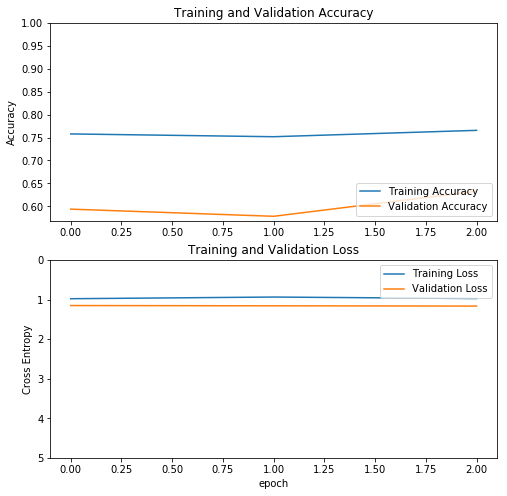

In [36]:
acc = history.history["acc"]
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([5,0.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Finetuning

In [0]:
fine_tune_at = 295
model.trainable=True
for layer in model.layers[0].layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001),  ## Adam에 0.0001로 할시 3번째 에포크에 약 70%val 달성 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 401,411
Non-trainable params: 21,407,520
_________________________________________________________________


In [44]:
len(model.trainable_variables)

9

In [45]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                    epochs=total_epochs,
                    initial_epoch=initial_epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [cp_callback],
                    validation_data=val_ds,
                    validation_steps=val_step,
                    )

Epoch 4/8
17/18 [===========================>..] - ETA: 9s - loss: 0.8573 - acc: 0.7472 
Epoch 00004: saving model to /gdrive/My Drive/img_dataset/beer_dataset/traint/cp-FineTunend-0004.ckpt
18/18 [==============================] - 185s 10s/step - loss: 0.8612 - acc: 0.7422 - val_loss: 1.0677 - val_acc: 0.5312
Epoch 5/8
17/18 [===========================>..] - ETA: 8s - loss: 0.8157 - acc: 0.7307 
Epoch 00005: saving model to /gdrive/My Drive/img_dataset/beer_dataset/traint/cp-FineTunend-0005.ckpt
18/18 [==============================] - 170s 9s/step - loss: 0.8104 - acc: 0.7274 - val_loss: 1.0941 - val_acc: 0.5469
Epoch 6/8
17/18 [===========================>..] - ETA: 8s - loss: 0.7825 - acc: 0.6985 
Epoch 00006: saving model to /gdrive/My Drive/img_dataset/beer_dataset/traint/cp-FineTunend-0006.ckpt
18/18 [==============================] - 169s 9s/step - loss: 0.7800 - acc: 0.6953 - val_loss: 1.1264 - val_acc: 0.5938
Epoch 7/8
17/18 [===========================>..] - ETA: 8s - loss:

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

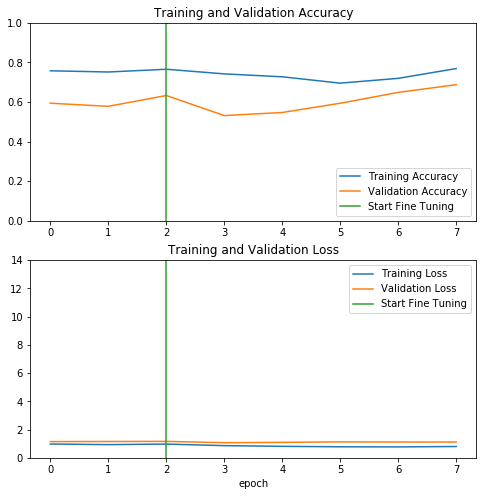

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Save Phase

## Save tflite file

In [69]:
h5_file = pth+"Revised_lienar.h5"
keras.models.save_model(model,h5_file,include_optimizer=True)

W0606 07:10:02.077372 139934958139264 saving_utils.py:162] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).


In [70]:
Converter = tf.lite.TFLiteConverter.from_keras_model_file(h5_file)
tflite_model = Converter.convert()
open(pth+"Revised_linear_ver2.tflite","wb").write(tflite_model)

W0606 07:10:30.851234 139934958139264 hdf5_format.py:197] No training configuration found in save file: the model was *not* compiled. Compile it manually.


87144384

In [0]:
print(tf.__version__)

## Load Check

In [68]:
h5_file = pth+"Revised_lienar.h5"
new_model = keras.models.load_model(h5_file)
new_model.summary()

W0606 07:08:10.005241 139934958139264 hdf5_format.py:197] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 401,411
Non-trainable params: 21,407,520
_________________________________________________________________


In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [0]:
opt = tf.train.AdamOptimizer(learning_rate=0.001)
new_model.compile(optimizer=opt, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [73]:
loss,acc = new_model.evaluate(val_ds, steps=val_step)
print("복원된 모델의 validation 정확도: {:5.2f}%".format(100*acc))

2/2 [==============================] - 17s 8s/step - loss: 1.1171 - acc: 0.6875
복원된 모델의 validation 정확도: 68.75%
